In [6]:
# !pip install xgboost

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas_profiling as pdp
import seaborn as sns
import time
import math
import datetime
from sklearn.linear_model import RandomizedLogisticRegression, LogisticRegression
from sklearn.feature_selection import RFECV, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
import scipy.stats as st
import random

%matplotlib inline

In [8]:
# !pip install pandas-profiling

In [9]:
traps = pd.read_csv('assets/train.csv')
test = pd.read_csv('assets/test.csv')
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')

In [10]:
pdp.ProfileReport(traps)

Number of variables,12
Number of observations,10506
Total Missing (%),0.0%
Total size in memory,985.0 KiB
Average record size in memory,96.0 B
Numeric,5
Categorical,6
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [11]:
## We can tackle the multiple addresses and the grouping in this one step
traps = traps[['Trap',
               'Latitude',
               'Longitude',
               'Date',
               'Species',
               'WnvPresent',
               'NumMosquitos']].groupby(['Trap',
                                         'Latitude',
                                         'Longitude',
                                         'Date', 
                                         'Species',
                                         'WnvPresent']).agg({'NumMosquitos':np.sum}).reset_index()

feats = traps.columns

## get species dummies and add to traps df
traps = pd.get_dummies(traps, columns=['Species'])

## convert to date
traps.Date = pd.to_datetime(traps.Date)

In [12]:
test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

In [13]:
# The test data doesn't include NumMosquitos... 
# this means we should drop this column from traps 
# and then drop the duplicates

traps.drop('NumMosquitos',axis=1,inplace=True)
traps.drop_duplicates(inplace=True)


## Might as well go ahead and perform the same modifications on the test data

# remove the redundant address features from test
test = test[feats.drop(['WnvPresent','NumMosquitos'])]

## get species dummies and add to traps df
test = pd.get_dummies(test, columns=['Species'])

## convert to date
test.Date = pd.to_datetime(test.Date)

In [14]:
pdp.ProfileReport(spray)

Number of variables,4
Number of observations,14835
Total Missing (%),1.0%
Total size in memory,463.7 KiB
Average record size in memory,32.0 B
Numeric,2
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [15]:
spray.Date = pd.to_datetime(spray.Date)

In [16]:
spray.duplicated().sum()

541

In [17]:
# Drop the duplicate records
spray.drop_duplicates(inplace=True)

In [18]:
pdp.ProfileReport(weather)

Number of variables,22
Number of observations,2944
Total Missing (%),0.0%
Total size in memory,506.1 KiB
Average record size in memory,176.0 B
Numeric,4
Categorical,15
Boolean,1
Date,0
Text (Unique),0
Rejected,2


In [19]:
weather.Date = pd.to_datetime(weather.Date)

In [20]:
exclude = ['Depart','Heat','Cool','Sunrise','Sunset','Depth','Water1','SnowFall']
include = weather.columns.drop(exclude)
weather = weather[include]

weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
       'CodeSum', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

In [21]:
# clean up features that should be numeric

# the PrecipTotal column contains the letter 'T' in some rows
# this indicates a 'trace' amount of precipitation, which is
# defined as less than 0.005
# 'M' indicates missing data

def clean_col(column):
    weather[column] = weather[column].str.replace('T','0.005')
    weather[column] = weather[column].str.replace('M','0.0')
    weather[column] = weather[column].astype(float)


    
clean_col('Tavg')
clean_col('PrecipTotal')
clean_col('WetBulb')
clean_col('StnPressure')
clean_col('SeaLevel')
clean_col('AvgSpeed')
# columns = ['Tavg','PrecipTotal','WetBulb','StnPressure','SeaLevel','AvgSpeed']
# for col in columns:
#     clean_col(col)

# If the CodeSum contains letters, they signify some type
# of significant weather event. Let's instead flag these as 1
# and then 0 for the values that are just whitespace
weather.CodeSum = weather.CodeSum.str.strip()
weather.CodeSum[weather.CodeSum.str.contains('^\w')] = '1'
weather.CodeSum[weather.CodeSum!='1'] = '0'
weather.CodeSum = weather.CodeSum.astype(float)

# fill in missing Tavg by just taking the avg of Tmin and Tmax
# while this is not how Tavg is calculated, but it's probably close
weather['Tavg'][weather.Tavg==0] = (weather.Tmin + weather.Tmax) / 2

C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jerome\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


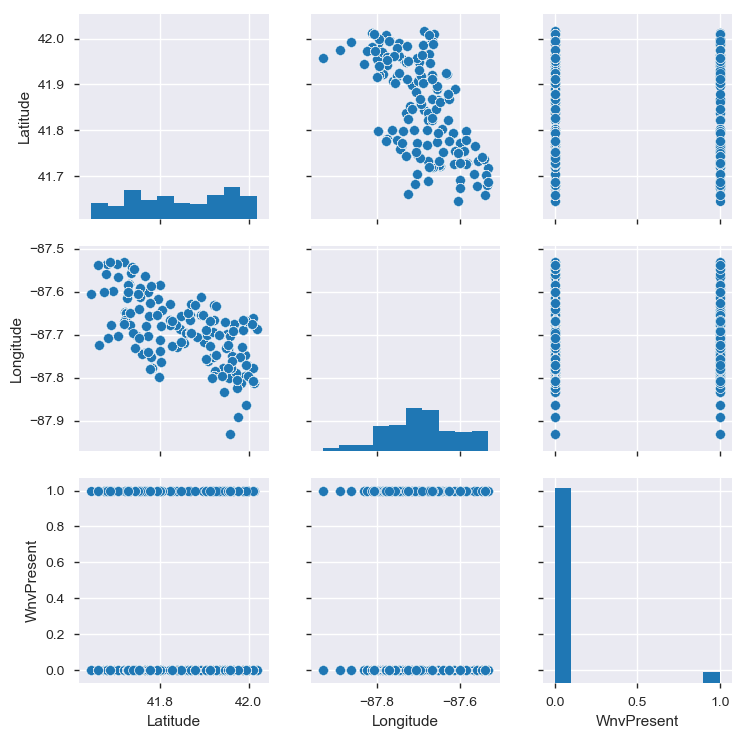

In [22]:
no_dummies = [x for x in traps.columns if not 'Species_' in x]
sns.pairplot(traps[no_dummies])

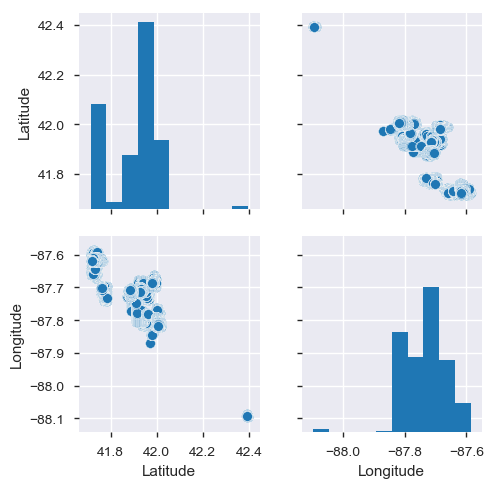

In [23]:
sns.pairplot(spray)

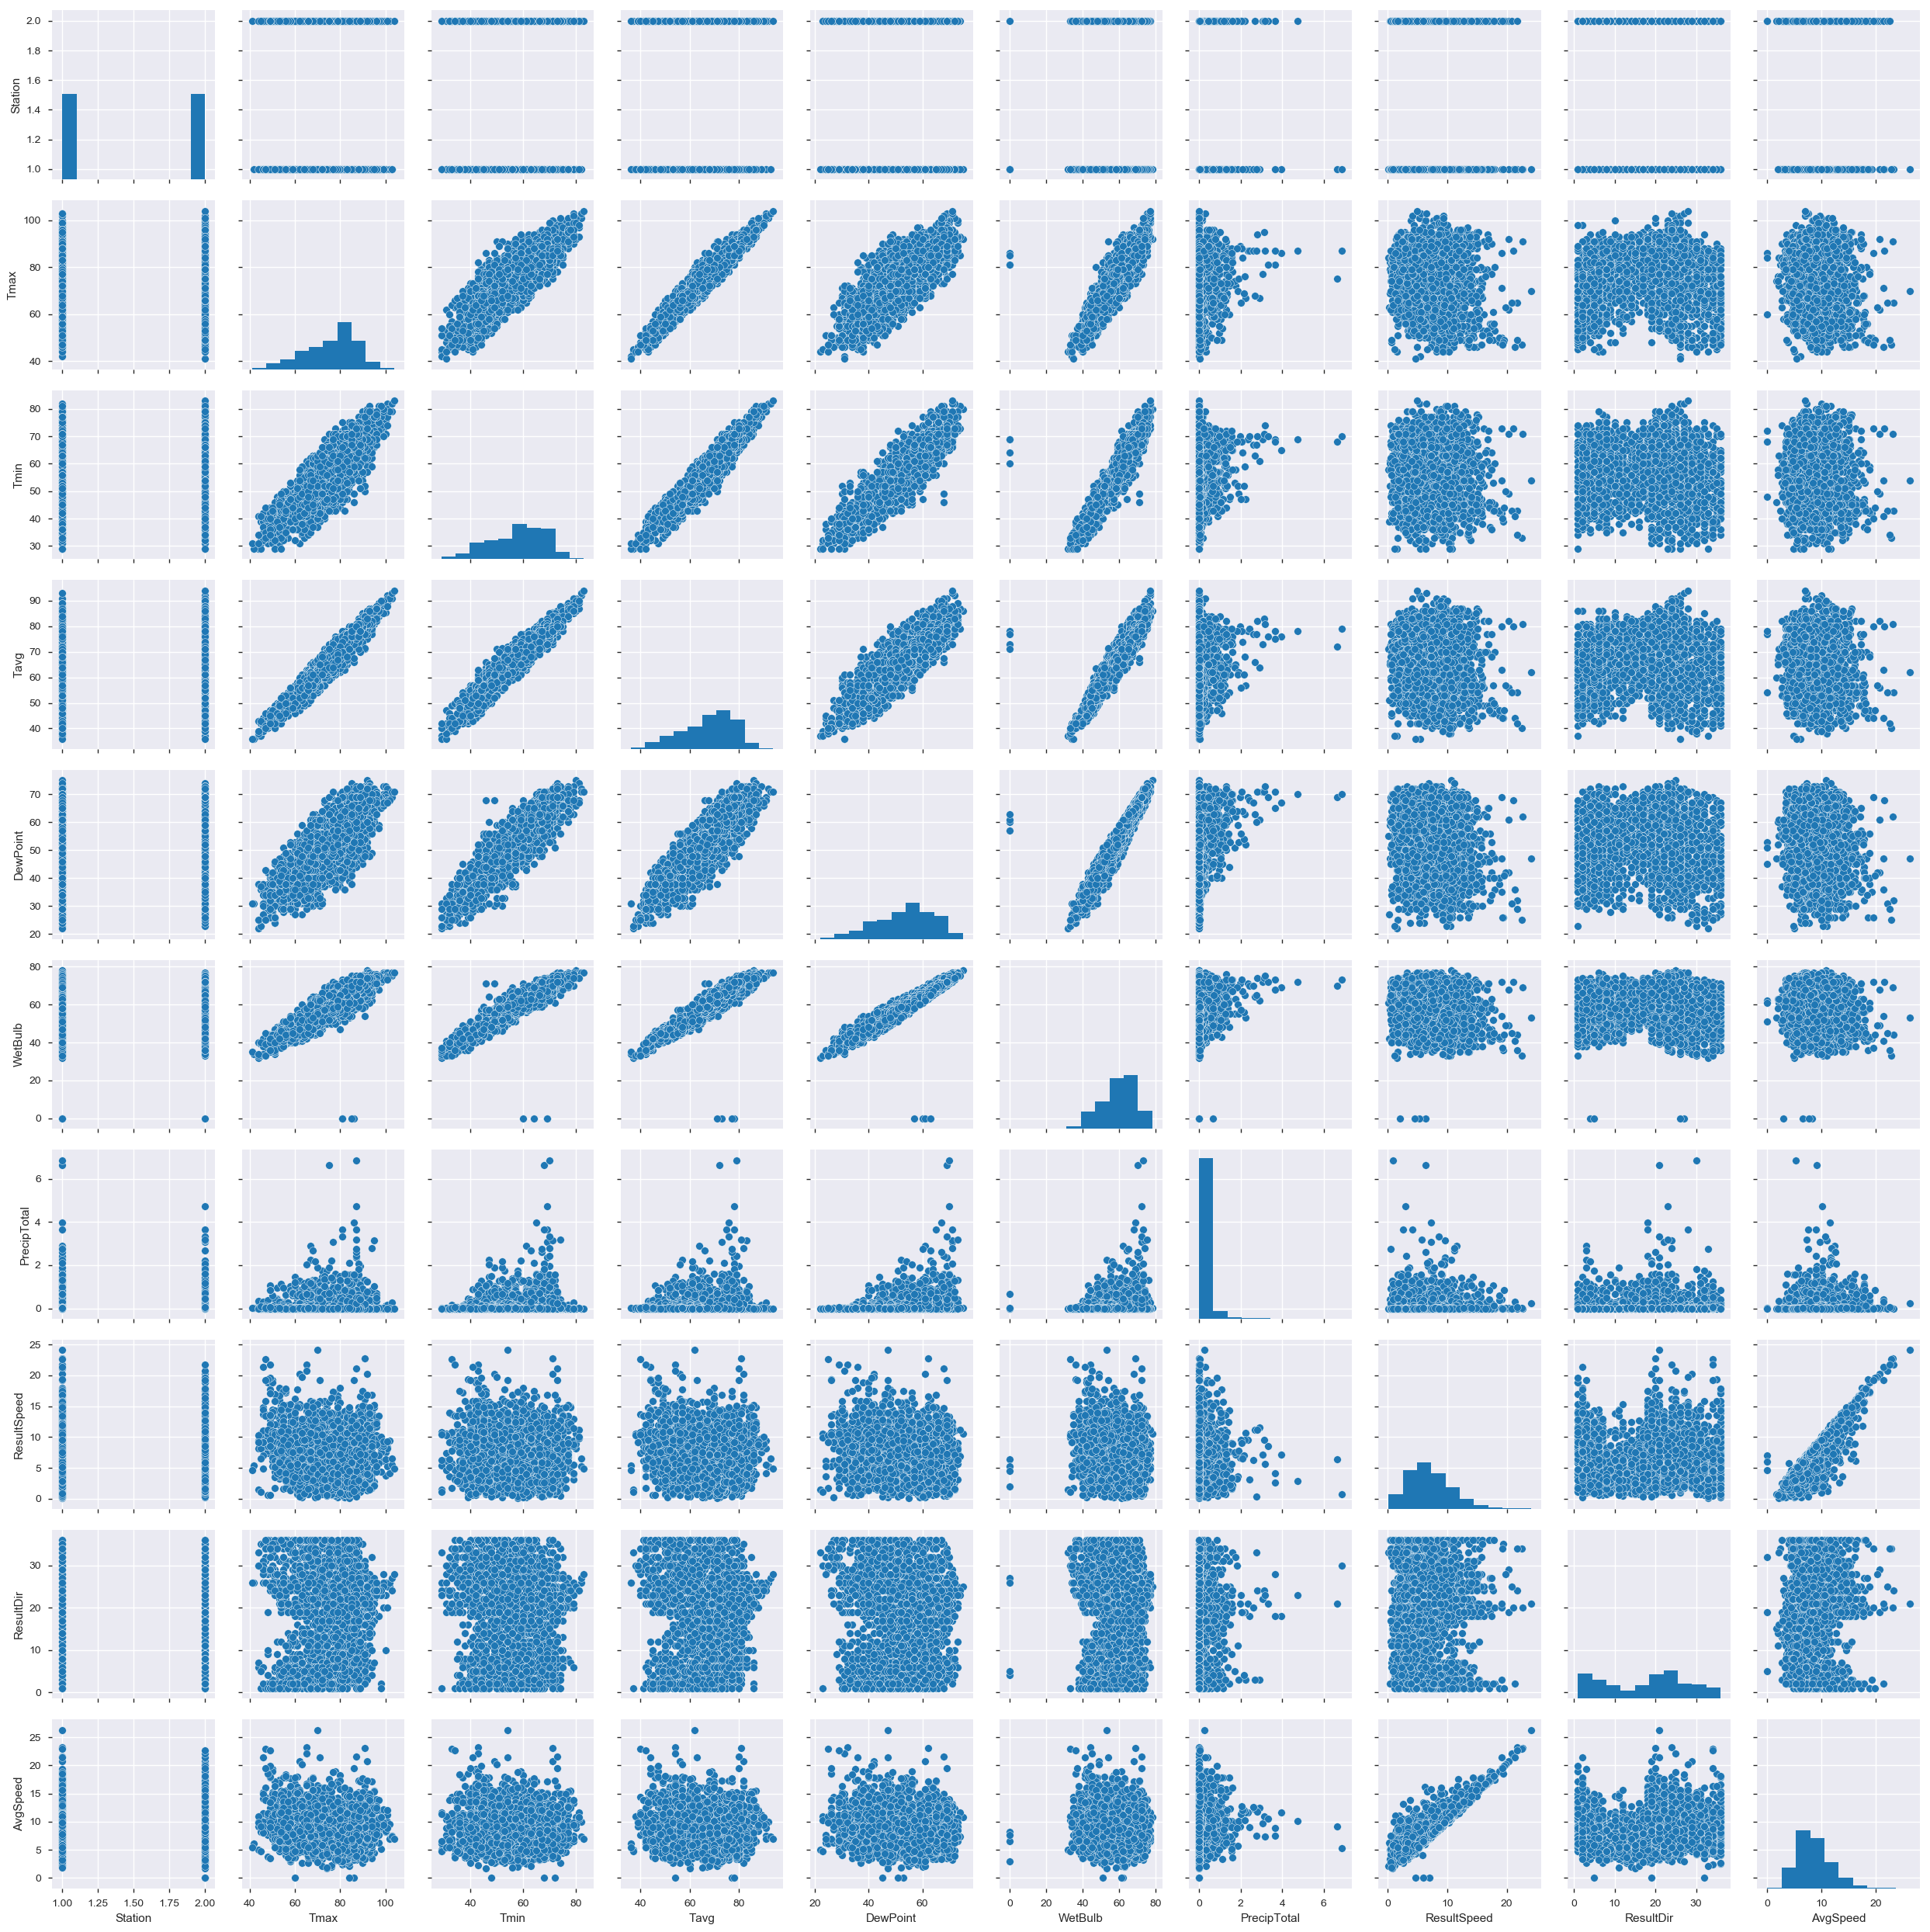

In [24]:
no_dummies = weather.columns.drop(['CodeSum','SeaLevel','StnPressure'])
sns.pairplot(weather[no_dummies])

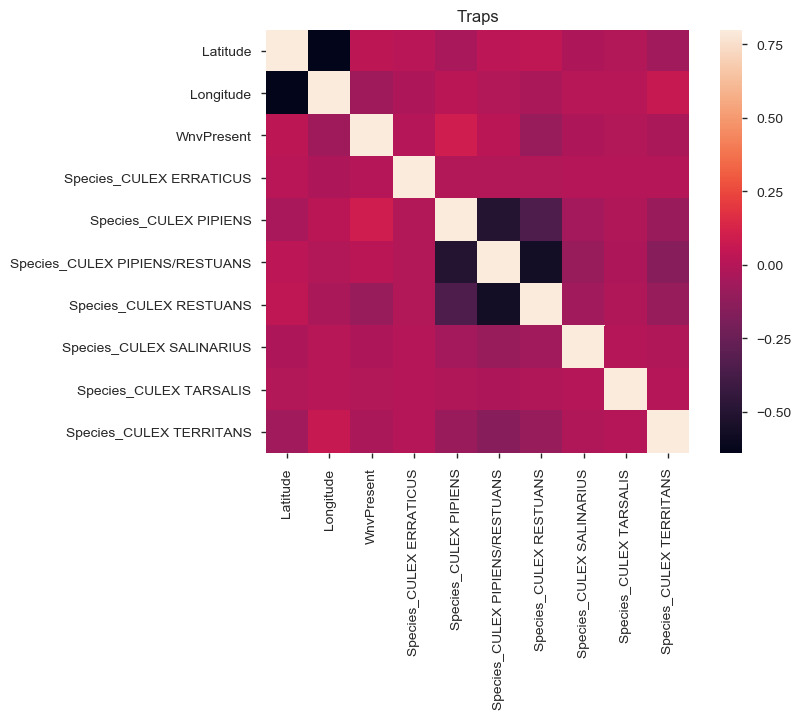

In [25]:
#Before adding anything, let's see what the feature correlation looks like
def find_correlation(data,title):
    correlation = data.corr()
    sns.heatmap(correlation, vmax=.8, square=True)
    plt.title(title)

find_correlation(traps, 'Traps')

In [26]:
## Parse Dates to see if they can be used in the modeling
traps['year']  = traps['Date'].dt.year
traps['month'] = traps['Date'].dt.month
traps['day']   = traps['Date'].dt.day

In [27]:
def weather_add(df, weather_col, func, days_range=7):
    new_list = []
    for i in df['Date']:
        mask = (weather['Date'] <= i) & (weather['Date'] >= i - pd.Timedelta(days=days_range))
        data_list = func(weather[weather_col][mask])
        new_list.append(data_list)
    return new_list

In [28]:
## running this cell will extract the average temp min, average temp max, and precipitation sum 
## to the traps dataframe from the previous 7 days, unless otherwise specified

traps['Tmax']    = weather_add(traps, weather_col='Tmax', func=np.mean)
traps['Tmin']    = weather_add(traps, weather_col='Tmin', func=np.mean)
traps['PrecipTotal']    = weather_add(traps, weather_col='PrecipTotal', func= np.sum)
traps['Tmax_3']  = weather_add(traps, weather_col='Tmax', func=np.mean, days_range=3)
traps['Tmax_20'] = weather_add(traps, weather_col='Tmax',func=np.mean, days_range=20)
traps['DewPoint']     = weather_add(traps, weather_col ='DewPoint', func=np.mean, days_range = 10)
traps['Tmin_3']  = weather_add(traps, weather_col='Tmin', func=np.mean, days_range=3)
traps['Tmin_20'] = weather_add(traps, weather_col='Tmin', func=np.mean, days_range=20)

for col in ['Tavg','WetBulb','CodeSum','StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir','AvgSpeed']:
    traps[col] = weather_add(traps, weather_col=col, func=np.mean)

In [29]:
def add_cols(traps,start,stop,col,Spray_col):
    # ex) I want the week leading up to the inspection date: start = 0, end = 7
    # ex) I want the week before that: start = 7, end = 14
    from geopy.distance import vincenty
    traps_sprayed = traps[traps[Spray_col].isnull()].index.values
    remaining = len(traps_sprayed)   
    
    for i in traps_sprayed:
        if start>0: # subtract # of days from the date the trap is inspected
            start_date = traps.Date.loc[i] - pd.Timedelta(days=start) 
        else: # if start=0, then we're starting on the trap inspection day and collecting data backwards
            start_date = traps.Date.loc[i]
        end_date = traps.Date.loc[i] - pd.Timedelta(days=stop)
        dates = pd.date_range(start=end_date, end=start_date).tolist() # create list of all dates in our start, end points
        trap_lat = traps.Latitude.loc[i]
        trap_long = traps.Longitude.loc[i]
        dist = []

        # for each dated trap inspection, select only the spray records within the date range
        spray_temp = spray[['Latitude','Longitude','Date']][spray.Date.isin(dates)]
        
        remaining-=1 # counts how many records are left to process
        print (str(remaining),' remaining')

        # run through each coordinate in the spray data and record the distance from our trap
        for j in range(0,len(spray_temp)):
            spray_lat = spray_temp.Latitude.iloc[j] 
            spray_long = spray_temp.Longitude.iloc[j]
            a = (trap_lat, trap_long) # trap coordinates
            b = (spray_lat, spray_long) # spray coordinates
            dist.append(vincenty(a, b).miles) # calculate the distance between the points
        
        try:
            # set the spray value to the shortest distance
            traps[Spray_col].loc[i] = min(dist)
            dt = dist.index(min(dist))
            spray_dt = spray_temp.Date.iloc[dt]
            # record the number of days from inspection that the nearest spray occurred
            traps[col].loc[i] = pd.Timedelta(traps.Date.loc[i]-spray_dt).days
        except:
            pass

In [30]:
traps.columns

Index(['Trap', 'Latitude', 'Longitude', 'Date', 'WnvPresent',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'year', 'month', 'day', 'Tmax', 'Tmin',
       'PrecipTotal', 'Tmax_3', 'Tmax_20', 'DewPoint', 'Tmin_3', 'Tmin_20',
       'Tavg', 'WetBulb', 'CodeSum', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

In [31]:
# !pip install msgpack

In [32]:
# !pip install geopy

In [33]:
# # get the indicies of trap data that actually have spray data
# traps_spray = traps[traps.year.isin([2011,2013])]

# # create the columns
# traps_spray['Spray_Dist'] = np.NaN
# traps_spray['Spray_Days_Ago'] = np.NaN

# # week leading up to inspection
# add_cols(traps_spray,0,7,'Spray_Days_Ago','Spray_Dist')
# #one week out
# add_cols(traps_spray,7,14,'Spray_Days_Ago','Spray_Dist')
# # two weeks out
# add_cols(traps_spray,14,21,'Spray_Days_Ago','Spray_Dist')
# # three weeks out
# add_cols(traps_spray,21,28,'Spray_Days_Ago','Spray_Dist')
# # four weeks out
# add_cols(traps_spray,28,35,'Spray_Days_Ago','Spray_Dist')

In [34]:
# Check to see how many values we were able to fill in
#traps['Spray'].isnull().sum()/float(len(traps['Spray']))

In [35]:
## Save the transformed tables so we don't have to run the earlier cells
# traps.to_csv('./assets/Train_transformed/traps_jd.csv', encoding='utf-8', index=False)

In [36]:
##re-import the altered traps file if re-running and want to skip steps above
# traps = pd.read_csv('./assets/Train_transformed/traps_jd.csv')

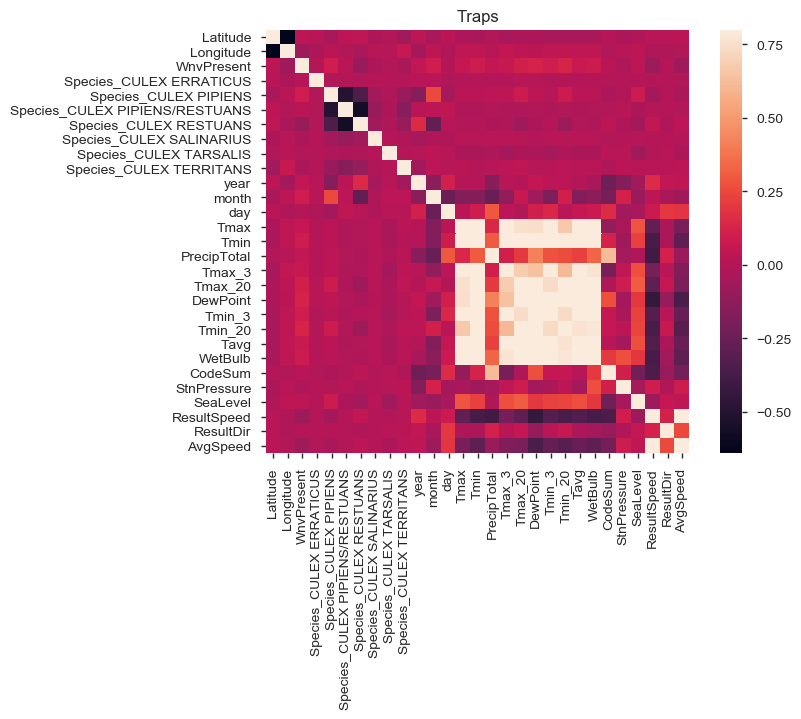

In [37]:
## Check out how the correlation map changed with our new features
find_correlation(traps, 'Traps')

In [38]:
# Get rid of features that we cannot use
features = traps.columns.drop(['WnvPresent','Date','Trap'])

X = traps[features]
y = traps.WnvPresent

In [39]:
X.columns

Index(['Latitude', 'Longitude', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'year', 'month',
       'day', 'Tmax', 'Tmin', 'PrecipTotal', 'Tmax_3', 'Tmax_20', 'DewPoint',
       'Tmin_3', 'Tmin_20', 'Tavg', 'WetBulb', 'CodeSum', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [40]:
# create a function that scales the data, takes the data
# and scores the features, storing it in a dictionary, ranks
def rank_to_dict(ranks, names, order=1):
    minmax = StandardScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

ranks = {}

lr = RandomizedLogisticRegression()
lr.fit(X, y)
ranks["Logistic"] = rank_to_dict(np.abs(lr.scores_), features)
    
rf = RandomForestClassifier()
rf.fit(X,y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, features)

f, pval  = f_classif(X, y)
ranks["F_Classif."] = rank_to_dict(f, features)

r = {}
for name in features:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())

# average out the scores
ranks["Mean"] = r
methods.append("Mean")


# Now that we have our data, convert to dataframe for better viewing
feats = []
names = []

# feature names
for i in ranks['RF']:
    names.append(i)

feats.append(names)

# feature importances
for i in ranks:
    row = []
    for j in ranks[i]:
        row.append(ranks[i][j])
    feats.append(row)

feats_t = []

for i in range(0,len(features)):
    row = []
    for f in feats:
        row.append(f[i])
    feats_t.append(row)

feature_importances = pd.DataFrame(feats_t,columns = ['Feature','F_Classif','Logistic','RF','Mean'])

C:\Users\jerome\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLogisticRegression is deprecated; The class RandomizedLogisticRegression is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [41]:
feature_importances.sort_values(['Mean'],ascending=False)

# feature_importances.sort_values(['Mean','F_Classif','Logistic','RF'],ascending=False)
# feature_importances.Feature

,Feature,F_Classif,Logistic,RF,Mean
1,Longitude,1.81,3.68,0.17,1.89
19,Tmin_20,1.88,-0.27,2.55,1.39
17,DewPoint,1.86,-0.25,2.24,1.28
3,Species_CULEX PIPIENS,2.08,-0.02,0.98,1.01
10,month,1.93,-0.18,1.01,0.92
5,Species_CULEX RESTUANS,1.71,-0.16,0.83,0.79
0,Latitude,-0.62,3.49,-0.82,0.68
16,Tmax_20,0.20,-0.29,1.33,0.41
18,Tmin_3,-0.05,-0.29,0.87,0.18
13,Tmin,-0.44,-0.32,0.71,-0.02


In [42]:
features_new = list(feature_importances.sort_values(['Mean','F_Classif','Logistic','RF'],ascending=False)['Feature'][0:9])
features_new.remove('Species_CULEX RESTUANS')

In [43]:
X = traps[features_new]
y = traps.WnvPresent

In [44]:
X_s = pd.DataFrame(StandardScaler().fit_transform(X[X.columns.drop('Species_CULEX PIPIENS')]),columns=X.columns.drop('Species_CULEX PIPIENS'))
X_s = pd.DataFrame(X['Species_CULEX PIPIENS']).merge(X_s,left_on=X.index.values, right_on=X_s.index.values)
X_s.drop('key_0',inplace=True,axis=1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.33, stratify=y)

C:\Users\jerome\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [46]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s,y,train_size=.33, stratify=y)

C:\Users\jerome\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [47]:
print ('Raw splits:')
print (X_train.shape, X_test.shape, y_test.shape, y_train.shape)
print()
print ('Scaled splits:')
print (X_train_s.shape, X_test_s.shape, y_test_s.shape, y_train_s.shape)

Raw splits:
(2841, 8) (5769, 8) (5769,) (2841,)

Scaled splits:
(2841, 8) (5769, 8) (5769,) (2841,)


In [48]:
def score_model(model,X_test,y_test):
    preds = model.predict_proba(X_test)
    pred_list =[]
    
    for x in preds:
        pred_list.append(x[1])
        
    roc_score = roc_auc_score(y_test, pred_list)
    return roc_score

In [49]:
RF = RandomForestClassifier(n_estimators = 1000, 
                            bootstrap=True, 
                            max_depth=5,
                            max_features='auto',
                            min_samples_leaf= 1, 
                            min_samples_split= 2)

In [50]:
RF_model= RF.fit(X_train, y_train)
score_model(RF_model,X_test,y_test)

0.8144717463530656

In [51]:
RF_model_s = RF.fit(X_train_s, y_train_s)
score_model(RF_model_s,X_test_s, y_test_s)

0.8126442412952735

In [52]:
svmc= SVC(probability=True)
svm_model = svmc.fit(X_train,y_train)
score_model(svm_model,X_test,y_test)

0.728890372428183

In [53]:
svm_model_s = svmc.fit(X_train_s,y_train_s)
score_model(svm_model_s,X_test_s,y_test_s)

0.7047882427118141

In [ ]:
clf1 = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf1.fit(X_train, y_train)

In [68]:
print (clf1.score(X_test,y_test), score_model(clf1,X_test,y_test))

0.618131391922 0.758083195448


In [69]:
n_estimators = 10
clf2 = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
clf2.fit(X_train, y_train)


OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.1, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          n_jobs=1)

In [71]:
print (clf2.score(X_test,y_test), score_model(clf2,X_test,y_test))

0.753163459872 0.750562608349


In [72]:
clf1s = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf1s.fit(X_train_s, y_train_s)


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [73]:
print (clf1s.score(X_test_s,y_test_s), score_model(clf1s,X_test_s,y_test_s))

0.646732535968 0.765533792991


In [74]:
n_estimators = 10
clf2s = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
clf2s.fit(X_train_s, y_train_s)

OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.1, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          n_jobs=1)

In [75]:
print (clf2s.score(X_test_s,y_test_s), score_model(clf2s,X_test_s,y_test_s))

0.679493846421 0.763601602701


In [77]:
def log(X,y,X_test,y_test):
    # flatten y into a 1-D array
    y_log = np.ravel(y)
    model = LogisticRegression()
    model = model.fit(X, y)
    predicted = model.predict(X_test)
    probs = model.predict_proba(X_test)
    scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
    print ('Mean CV score: ' + str(scores.mean()))
    print ('Accuracy score: ' + str(metrics.accuracy_score(y_test, predicted)))
    print ('Roc-auc score: ' + str(metrics.roc_auc_score(y_test, probs[:, 1])))
    print ('')
    print ('Confusion matrix: \n' + str(metrics.confusion_matrix(y_test, predicted)))
    print ('Classification report: \n' + str(metrics.classification_report(y_test, predicted)))
    # check the accuracy on the training set
    print ('Model score: ' + str(model.score(X_test, y_test)))
    print ('Kaggle: ' + str(score_model(model,X_test,y_test)))
    print ('')


log(X_train,y_train,X_test,y_test)
log(X_train_s,y_train_s,X_test_s,y_test_s)

Mean CV score: 0.946850753645
Accuracy score: 0.946957878315
Roc-auc score: 0.73962808627

Confusion matrix: 
[[5463    0]
 [ 306    0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      5463
          1       0.00      0.00      0.00       306

avg / total       0.90      0.95      0.92      5769

Model score: 0.946957878315
Kaggle: 0.73962808627

Mean CV score: 0.946850753645
Accuracy score: 0.946957878315
Roc-auc score: 0.767705862014

Confusion matrix: 
[[5463    0]
 [ 306    0]]
Classification report: 
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      5463
          1       0.00      0.00      0.00       306

avg / total       0.90      0.95      0.92      5769

Model score: 0.946957878315
Kaggle: 0.767705862014



C:\Users\jerome\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jerome\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
# flatten y into a 1-D array
y_log = np.ravel(y_train_s)
log_model = LogisticRegression()
log_model = log_model.fit(X_train_s, y_train_s)

In [81]:
adaboost= AdaBoostClassifier()
ada_model=adaboost.fit(X,y)
score_model(ada_model,X_test,y_test)

0.85148156522966745

In [127]:
def GradBoostClass(X_train,y_train,X_test,y_test):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
    clf.score(X_test, y_test)   
    print (score_model(clf,X_test,y_test))
    print ('')

# GradBoostClass(X_train,y_train,X_test,y_test)
# GradBoostClass(X_train_s,y_train_s,X_test_s,y_test_s)
clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
print (clf3.score(X_test, y_test))  
print (score_model(clf3,X_test,y_test))
print ('')

0.945397815913
0.819688361036



In [84]:
model = XGBClassifier()
xgm = model.fit(X_train, y_train, eval_metric=roc_auc_score)
score_model(xgm,X_test,y_test)

0.81891279301396569

In [105]:
params = {  
    "n_estimators": [4,5,7],
    "max_depth": [5, 10, 15],
    "learning_rate": [0.2, 0.3, 0.4]
}

xgbclass = XGBClassifier()

In [106]:
gs = GridSearchCV(xgbclass,  params, n_jobs=-1, scoring='roc_auc')
gs.fit(X_train, y_train)  

gs.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [107]:
xg_grid = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

xg_final = xg_grid.fit(X_train, y_train)
score_model(xg_final,X_test,y_test)

0.77846002639264256

In [108]:
## Add features
# test['Tmax_20'] = weather_add(test, weather_col='Tmax',func=np.mean, days_range=20)
# test['DewPoint']= weather_add(test, weather_col ='DewPoint', func=np.mean, days_range = 10)
# test['Tmin_3'] = weather_add(test, weather_col='Tmin', func=np.mean, days_range=3)
# test['Tmin_20'] = weather_add(test, weather_col='Tmin', func=np.mean, days_range=20)

# test['month'] = test['Date'].dt.month

In [111]:
## Export the tranformed test data to a folder in the repo 
## so we don't have to run the above cells every time

# test.to_csv('./assets/Test_transformed/test_transformed_916.csv',sep=',', encoding='utf-8')

In [ ]:
# test = pd.read_csv('./assets/Test_transformed/test_transformed_427.csv')

In [112]:
test_X = test[features_new]

In [113]:
test_s = pd.DataFrame(StandardScaler().fit_transform(test_X[test_X.columns.drop(['Species_CULEX PIPIENS'])]),columns=test_X.columns.drop(['Species_CULEX PIPIENS']))
test_s = pd.DataFrame(test_X[['Species_CULEX PIPIENS']]).merge(test_s,left_on=test_X.index.values, right_on=test_s.index.values)
test_s.drop('key_0',inplace=True,axis=1)

In [118]:
def model_and_export(model, model_name,test_X=test_X):
    pred_list = []
    predictions =  model.predict_proba(test_X)
    for x in predictions:
        pred_list.append(x[1])
    indexes=np.arange(1, len(predictions)+1, 1)
    preds_df = pd.DataFrame(data=[indexes, pred_list]).T
    preds_df.columns =['Id','WnvPresent']
    preds_df['Id'] = preds_df.Id.astype(int)
    location = './submissions/{}_{}.csv'.format(model_name, time.strftime("%d_%m_%Y"))
    preds_df.to_csv(location, index=False)
    return

In [120]:
model_and_export(RF_model, 'RF_JD')
# Your submission scored 0.72874

In [121]:
model_and_export(log_model, 'LOG_JD',test_s)
# Your submission scored 0.72305

In [122]:
model_and_export(clf2s, 'SVM_S', test_s)
# Your submission scored 0.69906.

In [124]:
model_and_export(ada_model, 'ADABoost_JD')
# Your submission scored 0.74416.

In [128]:
model_and_export(clf3, 'GRADBOOST_')
# Your submission scored 0.64589

In [129]:
model_and_export(xgm, 'XG_JD')
# Your submission scored 0.75110

In [130]:
model_and_export(xg_final, 'XG_FINAL')
# Your submission scored 0.71567

In [131]:
def ensemble_and_export(model1,model2,test_X,file_name):
    pred_m1 = []
    predictions_m1 =  model1.predict_proba(test_X)
    pred_m2 = []
    predictions_m2 =  model2.predict_proba(test_X)

    for x in predictions_m1:
        pred_m1.append(x[1])

    for x in predictions_m2:
        pred_m2.append(x[1])

    indexes=np.arange(1, len(predictions_m1)+1, 1)

    preds_m1 = pd.DataFrame(data=[indexes, pred_m1]).T
    preds_m1.columns =['Id','WnvPresent']
    preds_m1['Id'] = preds_m1.Id.astype(int)

    preds_m2 = pd.DataFrame(data=[indexes, pred_m2]).T
    preds_m2.columns =['Id','WnvPresent']
    preds_m2['Id'] = preds_m2.Id.astype(int)
    
    ensemble = preds_m1.merge(preds_m2,left_on='Id', right_on='Id')
    
    ensemble['avg'] = (ensemble['WnvPresent_x']+ ensemble['WnvPresent_y']) / 2
    ensemble.rename(columns={'avg':'WnvPresent'},inplace=True)

    ensemble = ensemble[['Id','WnvPresent']]

    location = './submissions/{}_{}.csv'.format(file_name, time.strftime("%d_%m_%Y"))
    ensemble.to_csv(location, index=False)

In [132]:
ensemble_and_export(xgm,ada_model,test_X,'Ensemble_XG_ADA')
# Your submission scored 0.70831.

In [133]:
ensemble_and_export(xgm,RF_model_s,test_X,'Ensemble_XG_RF')
# Your submission scored 0.70979.